##Determining student's future success based on different variables such as income, country and parent's qualification based on Neural Network, Tensorflow Decision Forest, XGBoost, K-Nearest Neighbour and Support Vector Machine algorithms.
###Random Search, from the tensorflow_decision_forests library, and Grid Search, from the SKlearn library, are also used for Hyper-parameter tunning.

In [2]:
#First we have to download some of the libraries as they are not all pre installed
!pip install ucimlrepo
!pip install xgboost
!pip install tensorflow_decision_forests -U -qq

In [49]:
#Now we load all the libraries needed
import numpy as np
import pandas as pd
from sklearn.preprocessing import minmax_scale
import tensorflow_decision_forests as tfdf
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, classification_report
from ucimlrepo import fetch_ucirepo
import xgboost
import matplotlib.pyplot as plt
import seaborn as sb
import tensorflow as tf
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import OneHotEncoder

In [4]:
  #We load the dataset from the UCI Machine Learning Repository which has a library itself for its data which makes the loading of the data easier
predict_students_dropout_and_academic_success = fetch_ucirepo(id=697)
df = predict_students_dropout_and_academic_success.data.features
y= predict_students_dropout_and_academic_success.data.targets

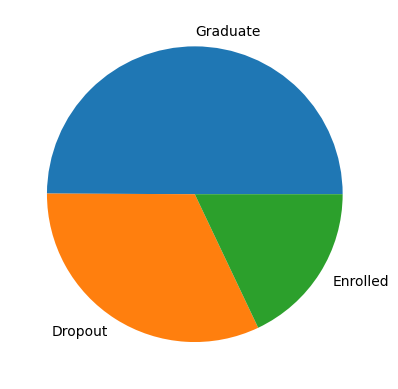

In [4]:
#First, we try to see our labels and thier percentage
vc= y['Target'].value_counts()
plt.pie(vc.values, labels=vc.index);

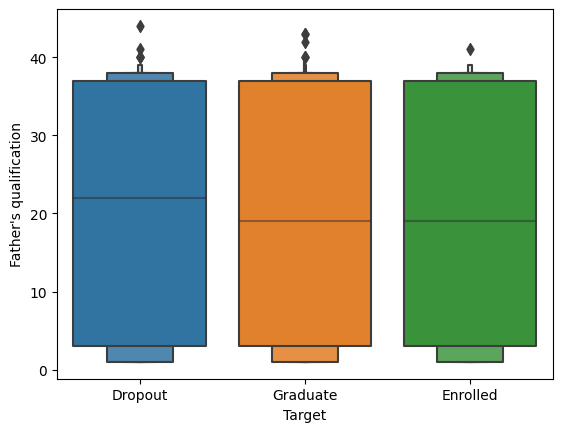

In [5]:
#Here, we can see the corelation between one's father's qualification and their academic success
sb.boxenplot(x= y['Target'], y=df["Father's qualification"])
plt.show()

In [5]:
#With this code we turn our target, which is one column of three strings, into one column for each of the Dropout, Graduate and Enrolled with one hot encoding
one_hot_encoder = OneHotEncoder(sparse=False)
one_hot_encoder.fit(y)
y_encoded = one_hot_encoder.transform(y)
y = pd.DataFrame(data=y_encoded, columns=one_hot_encoder.categories_)
print('\nAfter One Hot Encoding:')
display(y_encoded)


After One Hot Encoding:


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       ...,
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.]])

In [6]:
#The first model is the Neural Network with use of Tensorflow and Sequential model
#We also save the modelsperfomance epoch by epoch in a variable named history
model= tf.keras.models.Sequential([
    tf.keras.layers.Dense(64),
    tf.keras.layers.Dense(32),
    tf.keras.layers.Dense(16),
    tf.keras.layers.Dense(5),
    tf.keras.layers.Dense(3)])
model.compile(optimizer= tf.keras.optimizers.Adam(), loss= tf.keras.losses.CategoricalCrossentropy(from_logits= True) , metrics= ['accuracy', 'mse'])
history= model.fit(df, y, epochs=150, validation_split= 0.1, callbacks=[tf.keras.callbacks.CSVLogger("results.csv")])

Epoch 1/150
125/125 [==============================] - 4s 7ms/step - loss: 93.4985 - accuracy: 0.4202 - mse: 937934.3750 - val_loss: 20.7464 - val_accuracy: 0.2280 - val_mse: 827231.9375
Epoch 2/150
125/125 [==============================] - 0s 4ms/step - loss: 108.0816 - accuracy: 0.4047 - mse: 800965.1250 - val_loss: 65.4494 - val_accuracy: 0.5102 - val_mse: 668935.4375
Epoch 3/150
125/125 [==============================] - 1s 4ms/step - loss: 37.9610 - accuracy: 0.4928 - mse: 663310.0000 - val_loss: 31.1411 - val_accuracy: 0.5102 - val_mse: 623415.1875
Epoch 4/150
125/125 [==============================] - 1s 4ms/step - loss: 40.3472 - accuracy: 0.4883 - mse: 607162.1250 - val_loss: 23.7363 - val_accuracy: 0.6230 - val_mse: 585639.1250
Epoch 5/150
125/125 [==============================] - 1s 5ms/step - loss: 49.5525 - accuracy: 0.4607 - mse: 548531.6250 - val_loss: 28.4169 - val_accuracy: 0.4018 - val_mse: 531645.1250
Epoch 6/150
125/125 [==============================] - 1s 4ms/st

In [7]:
#Here we can see our models performance on the last 7 epochs
results=pd.read_csv("results.csv", index_col='epoch')
results.tail(7)

,accuracy,loss,mse,val_accuracy,val_loss,val_mse
epoch,,,,,,
143,0.732228,0.667554,106.773941,0.604966,0.862452,297.339874
144,0.714645,0.712281,325.207123,0.729120,0.656321,68.951294
145,0.713389,0.717513,133.207825,0.715576,0.662992,32.834869
146,0.724441,0.665303,82.372337,0.674944,0.837515,55.823971
147,0.685506,0.811251,484.027740,0.672686,0.838859,34.183968
148,0.715901,0.720672,101.451927,0.726862,0.647158,58.068577
149,0.719417,0.706840,385.952881,0.686230,0.741122,86.374710


In [8]:
#validation mean squared error of the last epoch
nn_loss= results.iloc[149][5]
nn_loss

86.37471008300781

In [9]:
#For the next model, we have to load the data agian as we have made some changes to the data for the neural network sequantial model
predict_students_dropout_and_academic_success = fetch_ucirepo(id=697)
df = predict_students_dropout_and_academic_success.data.features
y= predict_students_dropout_and_academic_success.data.targets

In [10]:
#With the use of Label Encoder we change the labels type from sting to entegr so that the model can process them
LE= LabelEncoder()
LE.fit(y['Target'])
y['Target']=LE.transform(y['Target'])
df['Target'] = y['Target']
df.head()

<ipython-input-10-5530fc2b5601>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['Target']=LE.transform(y['Target'])


,Marital Status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,0
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,2
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,0
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,2
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,2


<Axes: >

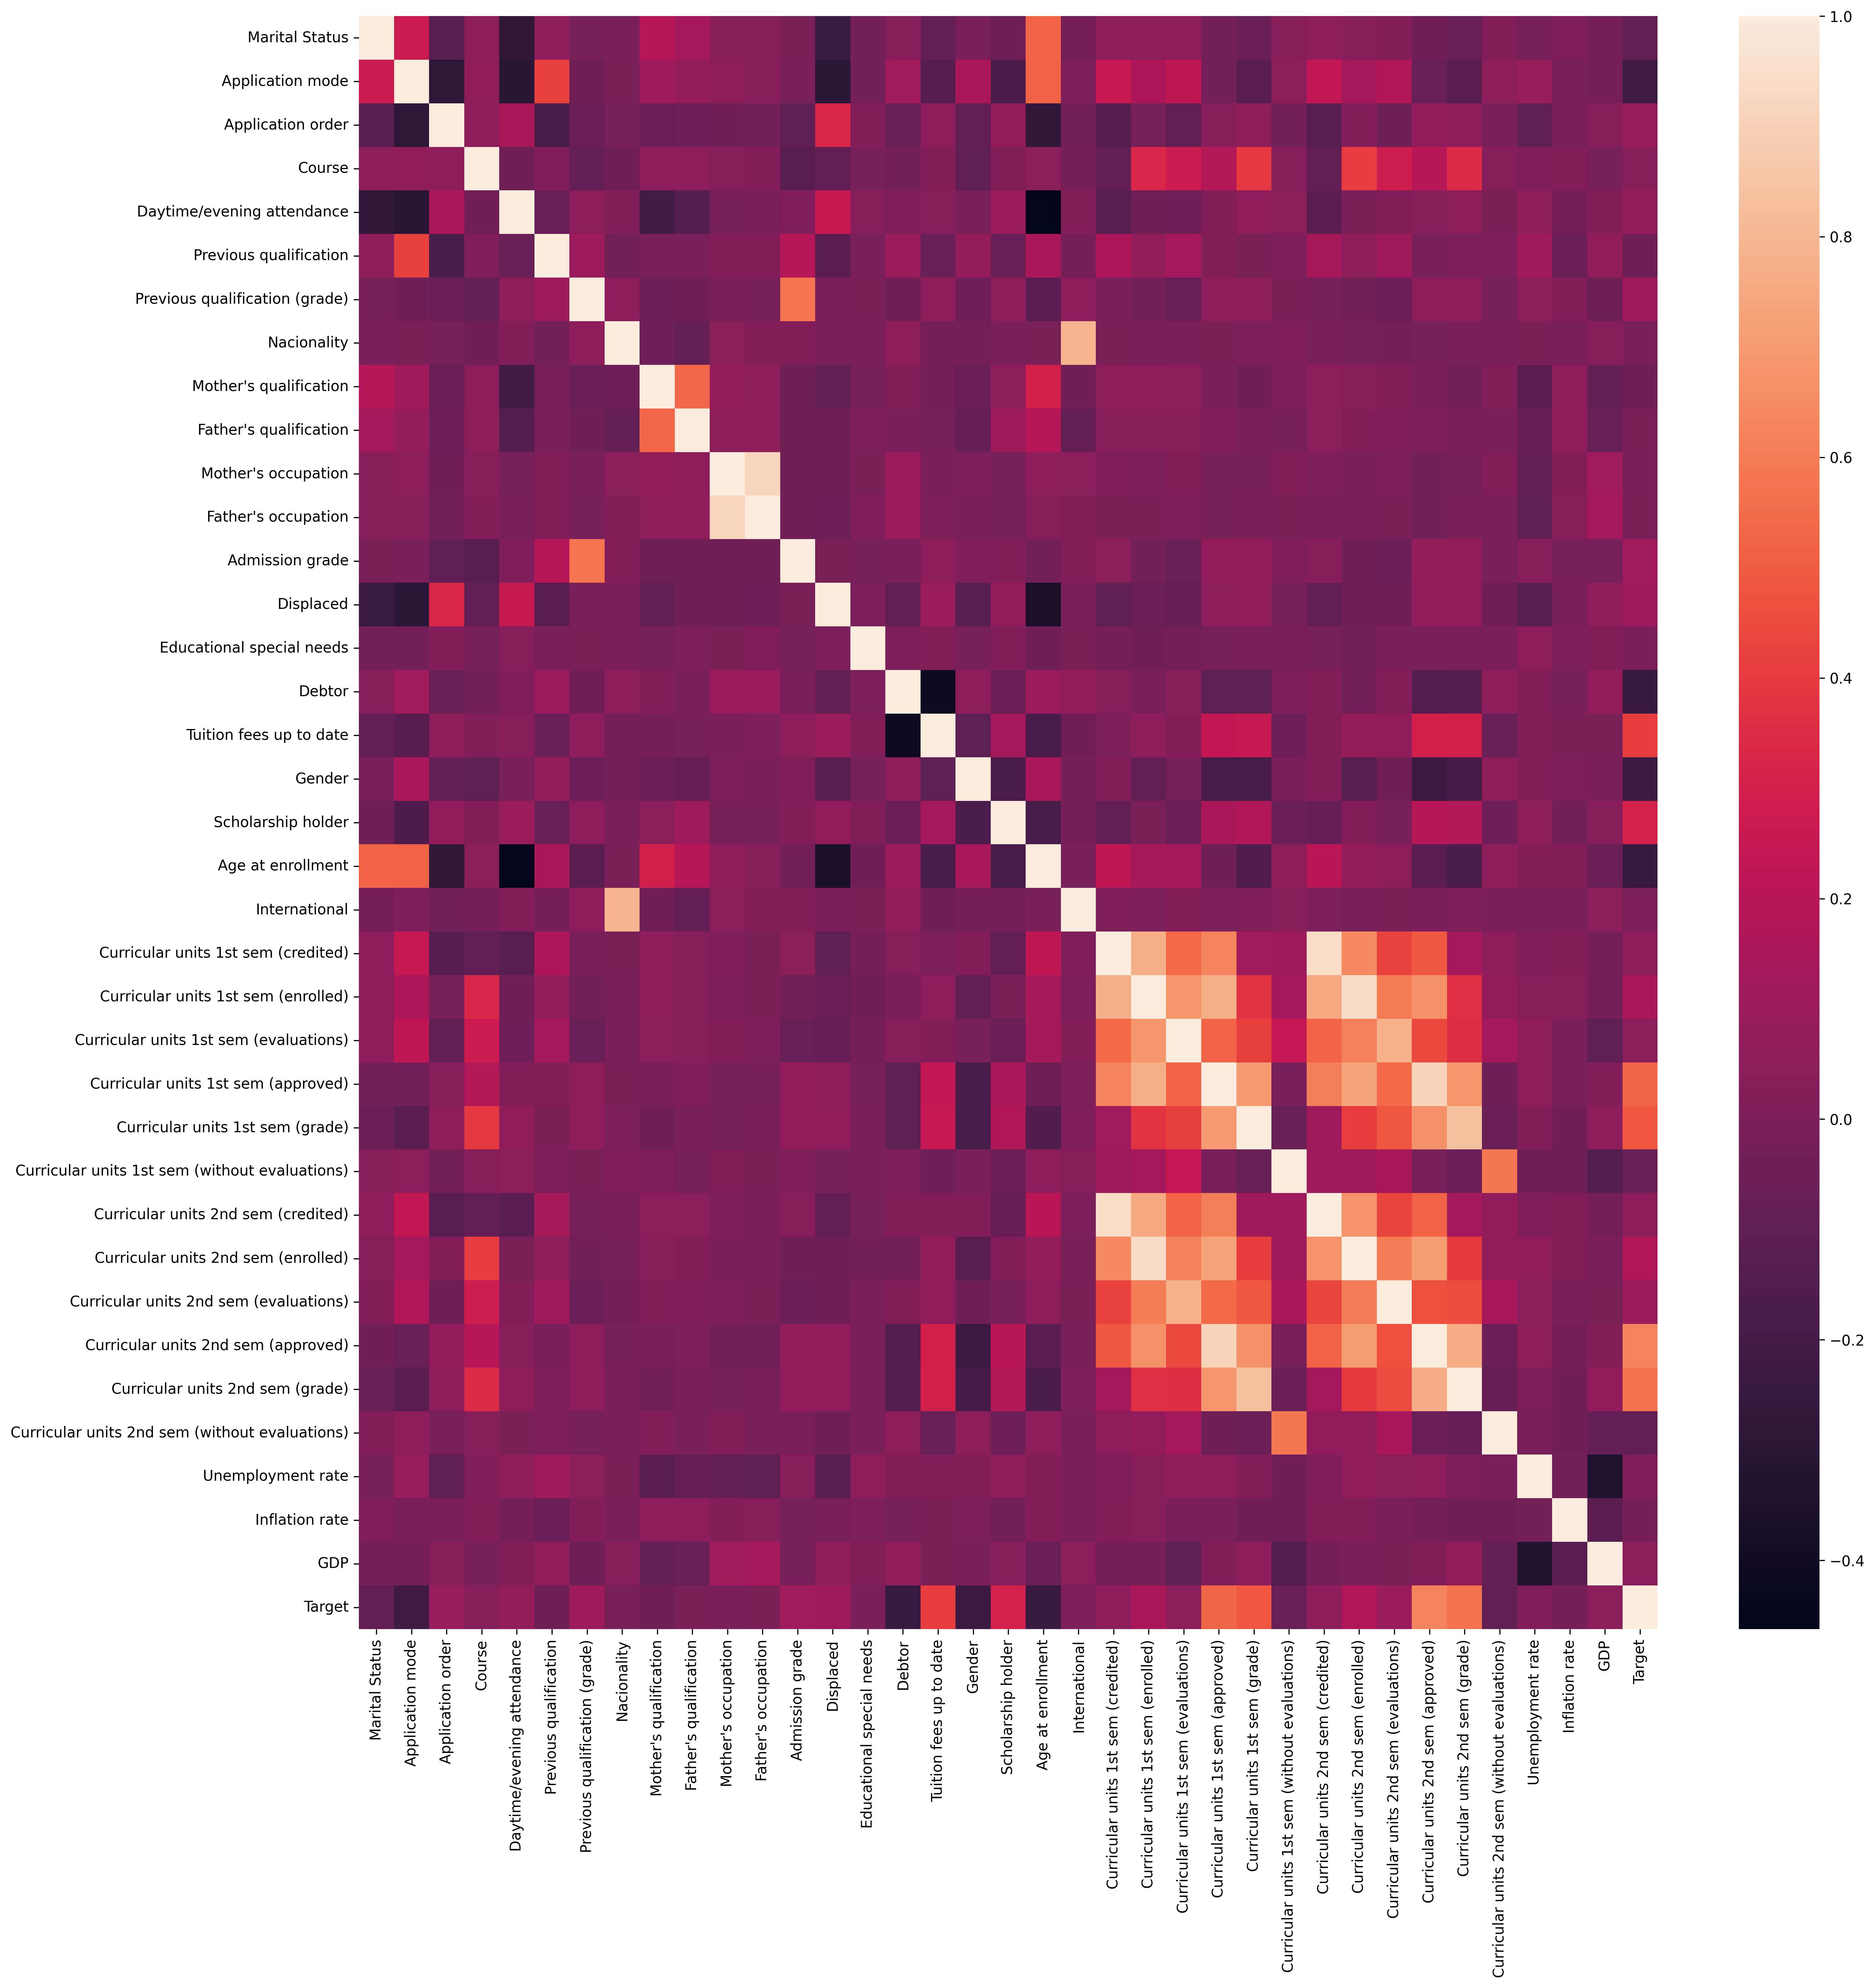

In [62]:
#This vizualization shows the relation between each of the features with one another and we can see that through a heatmap
plt.figure(figsize=(20,20), dpi=300)
corr= df.corr()
sb.heatmap(corr)

In [11]:
scale_df=minmax_scale(df, feature_range=(0,1))
#After scaling the data, the data will be a combination of raw numbers in ndarray numpy format and no longer in the pandas data frame which we need
#So now we will bring those numbers after normalization and put them in our original data frame using the pandas library:
df=pd.DataFrame(scale_df , index=df.index, columns=df.columns)

In [12]:
train, test= train_test_split(df, test_size=0.2)

In [13]:
#We change the data format to the one required for the tfdf processing by the tfdf.keras.pd_dataframe_to_tf_dataset code
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train, label='Target')
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test, label='Target')

In [14]:
#The Gradient Boost model with defualt parameters
model = tfdf.keras.GradientBoostedTreesModel()
model.fit(train_ds)

Use /tmp/tmp34cok6kk as temporary training directory
Reading training dataset...
Training dataset read in 0:00:04.574934. Found 3539 examples.
Training model...
Model trained in 0:00:02.108237
Compiling model...
Model compiled.


In [15]:
model.compile(['mse', "accuracy"])
tfdf_accuracy = model.evaluate(test_ds, return_dict=True, verbose=0)["accuracy"]
tfdf_mse= model.evaluate(test_ds, return_dict=True, verbose=0)["mse"]
print(f"Test accuracy without hyper-parameter tuning: {tfdf_accuracy:.4f}")
print(f"Test mse without hyper-parameter tuning: {tfdf_mse:.4f}")

Test accuracy without hyper-parameter tuning: 0.7345
Test mse without hyper-parameter tuning: 0.0921


In [16]:
#Now, with the use of RandomSearch algorithm we tune our model with parameters
tunerr = tfdf.tuner.RandomSearch(num_trials=150)
#More number of trails can improve the accuracy of the model but also slows down the tunning.
tunerr.choice("min_examples", [1, 2, 3, 5, 7, 9, 11])
tunerr.choice("categorical_algorithm", ["CART", "RANDOM"])
local_search_space = tunerr.choice("growing_strategy", ["LOCAL"])
local_search_space.choice("max_depth", [2, 3, 4, 5, 7, 10])
global_search_space = tunerr.choice("growing_strategy", ["BEST_FIRST_GLOBAL"], merge=True)
global_search_space.choice("max_num_nodes", [16, 32, 48, 64, 90, 128, 256])
tunerr.choice("use_hessian_gain", [True, False])
tunerr.choice("shrinkage", [0.02, 0.05, 0.07, 0.10, 0.15])
tunerr.choice("num_candidate_attributes_ratio", [0.2, 0.4, 0.7, 0.9, 1.0])

In [17]:
tuned_model = tfdf.keras.GradientBoostedTreesModel(tuner=tunerr)
tuned_model.fit(train_ds, verbose=0)

Use /tmp/tmprbm96aex as temporary training directory


In [18]:
#Evaluating the tunned model
tuned_model.compile(["accuracy"])
tuned_tfdf_accuracy = tuned_model.evaluate(test_ds, return_dict=True, verbose=0)["accuracy"]
tunned_tfdf_mse= model.evaluate(test_ds, return_dict=True, verbose=0)["mse"]
print(f"Test accuracy with the TF-DF hyper-parameter tuner: {tuned_tfdf_accuracy:.4f}")
print(f"Test mse without hyper-parameter tuning: {tunned_tfdf_mse:.4f}")

Test accuracy with the TF-DF hyper-parameter tuner: 0.7345
Test mse without hyper-parameter tuning: 0.0921


In [19]:
#Again for the next model we have to load the data
predict_students_dropout_and_academic_success = fetch_ucirepo(id=697)
df = predict_students_dropout_and_academic_success.data.features
y= predict_students_dropout_and_academic_success.data.targets
LE.fit(y['Target'])
y['Target']=LE.transform(y['Target'])
df['Target'] = y['Target']

<ipython-input-19-b1ade503c08f>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['Target']=LE.transform(y['Target'])


In [20]:
x=df.drop('Target', axis=1)
y= df.Target
x_train, x_test, y_train, y_test= train_test_split(x,y, test_size=0.2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3539, 36), (3539,), (885, 36), (885,))

In [21]:
#Now, we use the XGBoost model from the SKlearn library
#We use the defualt parameters at first
xgb=XGBClassifier()
xgb.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [22]:
xgb_pred= xgb.predict(x_test)
xgb_mse= mean_squared_error(y_test, xgb_pred)
print(f"Test mse without hyper-parameter tuning: {xgb_mse:.4f}")

Test mse without hyper-parameter tuning: 0.3548


In [22]:
#Now we want to tune our XGB model with the GridSearch algorithm
#First we will call the XGBoost model
xgb= XGBClassifier()
#since we want to use the grid search algorithm with the XGB model, we will first identify the parameters that we want the grid search algorithm to inspect
#the parameters of the model will be wtitten in a dictionary with each parameter mentioned and the options avaliable for each parameter
parametr={'eta':[0.04, 0.07, 0.1],
          'max_depth':[4, 6, 8],
          'subsample':[0.5, 0.8, 1],
          'lambda': [0.9, 1.3, 1.7]}
#there are more parameters and more options for a xgb classifier but for now we just use this much of the model's capacity
GS= GridSearchCV(xgb,parametr,cv=20,scoring='accuracy')
#a point that has to be mentioned here is that we are not yet using the model but we are just using the grid search algorithm to find the best paramters for the model
#Thus we don't fit the algorithm on X_train and Y_train because now we are just looking for the best paramteters and thus we fit it on the entier data (x,y)
GS.fit(x,y)

GridSearchCV(cv=20,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'eta': [0.04, 0.07, 0.1], 'lambda': [0.9, 1.3, 1.7],
                         'max_depth': [4, 6, 8], 'subsample': [0.5, 0.8, 1]},
             scoring='accuracy')

In [23]:
#We inspect the best score based on the metric mentioned in the argumet of the code in the above cell (accuracy)
GS.best_score_

0.7834546084546086

In [24]:
#And then we can see he best parameters that lead to that best score
GS.best_params_

{'eta': 0.07, 'lambda': 1.7, 'max_depth': 8, 'subsample': 0.8}

In [23]:
#Finally we will use the parameters given by the grid search algorithm in our XGBoost classifier model
tunned_xgb= XGBClassifier(eta= 0.07, lambda_= 1.7, max_depth= 8, subsample= 0.8)
#Here we fit our model on our data and use it to predict
tunned_xgb.fit(x_train,y_train)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [14:38:49] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "lambda_" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.07, eval_metric=None,
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None, lambda_=1.7,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, ...)

In [24]:
#In the End, we evaluate the XGBoost model with the parameters that we choose
tunned_xgb_pred=tunned_xgb.predict(x_test)
tunned_xgb_mse= mean_squared_error(y_test, tunned_xgb_pred)
print(f"Test mse with hyper-parameter tuning: {tunned_xgb_mse:.4f}")

Test mse with hyper-parameter tuning: 0.3695


In [25]:
#The next model we inspect is the K-Nearest Neighbour model from the SKlearn library
#We use the defualt parameters at first
knn=KNeighborsClassifier()
knn.fit(x_train, y_train)

KNeighborsClassifier()

In [26]:
knn_pred= knn.predict(x_test)
knn_mse= mean_squared_error(y_test, knn_pred)
print(f"Test mse without hyper-parameter tuning: {knn_mse:.4f}")

Test mse without hyper-parameter tuning: 0.8960


In [62]:
#Now we want to tune our KNN model with the GridSearch algorithm
#First we will call the KNN model
knn=KNeighborsClassifier()
#since we want to use the grid search algorithm with the KNN model, we will first identify the parameters that we want the grid search algorithm to inspect
#the parameters of the model will be wtitten in a dictionary with each parameter mentioned and the options avaliable for each parameter
parametr={'n_neighbors':[2, 3, 4, 5, 7, 9],
          'weights':['uniform', 'distance'],
          'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
          'p': [2, 1]}
#there are more parameters and more options for a KNN classifier but for now we just use this much of the model's capacity
knn_GS= GridSearchCV(knn,parametr,cv=20,scoring='accuracy')
#a point that has to be mentioned here is that we are not yet using the model but we are just using the grid search algorithm to find the best paramters for the model
#Thus we don't fit the algorithm on X_train and Y_train because now we are just looking for the best paramteters and thus we fit it on the entier data (x,y)
knn_GS.fit(x,y)

GridSearchCV(cv=20, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': [2, 3, 4, 5, 7, 9], 'p': [2, 1],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

In [63]:
#We inspect the best score based on the metric mentioned in the argumet of the code in the above cell (accuracy)
knn_GS.best_score_

0.6706626309567485

In [64]:
#And then we can see he best parameters that lead to that best score
knn_GS.best_params_

{'algorithm': 'auto', 'n_neighbors': 9, 'p': 1, 'weights': 'distance'}

In [27]:
#Now we will use the parameters given by the grid search algorithm in our KNN classifier model
tunned_knn= KNeighborsClassifier(algorithm= 'auto', n_neighbors= 9, p= 1, weights= 'distance')
#Here we fit our model on our data and use it to predict
tunned_knn.fit(x_train,y_train)

KNeighborsClassifier(n_neighbors=9, p=1, weights='distance')

In [28]:
#In the End, we evaluate the KNN model with the parameters that we choose
tunned_knn_pred=tunned_knn.predict(x_test)
tunned_knn_mse= mean_squared_error(y_test, tunned_knn_pred)
print(f"Test mse with hyper-parameter tuning: {tunned_knn_mse:.4f}")

Test mse with hyper-parameter tuning: 0.7277


In [29]:
#The next model we inspect is the Support Vector Machine model from the SKlearn library
#We use the defualt parameters at first
svm = svm.SVC()
svm.fit(x_train, y_train)

SVC()

In [30]:
svm_pred = svm.predict(x_test)
svm_mse= mean_squared_error(y_test, svm_pred)
print(f"Test mse without hyper-parameter tuning: {svm_mse:.4f}")

Test mse without hyper-parameter tuning: 1.5266


In [35]:
#since we want to use the grid search algorithm with the SVM model, we will first identify the parameters that we want the grid search algorithm to inspect
#the parameters of the model will be wtitten in a dictionary with each parameter mentioned and the options avaliable for each parameter
parametr={'C':[1, 2],
          'kernel':['linear', 'poly', 'rbf', 'sigmoid'],
          'degree':[2, 3, 4]}
#there are more parameters and more options for a xgb classifier but for now we just use this much of the model's capacity
svm_GS= GridSearchCV(svm,parametr,cv=20,scoring='neg_mean_absolute_error')
#a point that has to be mentioned here is that we are not yet using the model but we are just using the grid search algorithm to find the best paramters for the model
#Thus we don't fit the algorithm on X_train and Y_train because now we are just looking for the best paramteters and thus we fit it on the entier data (x,y)
svm_GS.fit(x,y)

GridSearchCV(cv=20, estimator=SVC(),
             param_grid={'C': [1, 2], 'degree': [2, 3, 4],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             scoring='neg_mean_absolute_error')

In [36]:
#We inspect the best score based on the metric mentioned in the argumet of the code in the above cell (mean squared error)
svm_GS.best_score_

-0.30357099180628594

In [37]:
#And then we can see he best parameters that lead to that best score
svm_GS.best_params_

{'C': 2, 'degree': 2, 'kernel': 'linear'}

In [51]:
#Now we will use the parameters given by the grid search algorithm in our SVM classifier model
from sklearn import svm as svc
tunned_svm= svc.SVC(C= 2, degree = 2, kernel = 'linear')
#Here we fit our model on our data and use it to predict
tunned_svm.fit(x_train,y_train)

SVC(C=2, degree=2, kernel='linear')

In [53]:
tunned_svm_pred=tunned_svm.predict(x_test)
tunned_svm_mse= mean_squared_error(y_test, tunned_svm_pred)
print(f"Test mse with hyper-parameter tuning: {tunned_svm_mse:.4f}")

Test mse with hyper-parameter tuning: 0.4316


In [58]:
#Finally, we can compare all of the models pefromances with this code as we can compare them side by side:
comparison_table= pd.DataFrame([['Neural Network', nn_loss/100],
                                ['Tensorflow Tree without tunning', tfdf_mse],
                                ['Tensorflow Tree with tunning', tunned_tfdf_mse],
                                ['XGBoost without tunning', xgb_mse],
                                ['XGBoost with tunning', tunned_xgb_mse],
                               ['KNN without tunning', knn_mse],
                                ['KNN with tunning', tunned_knn_mse],
                               ['SVM without tunning', svm_mse],
                                ['SVM with tunning', tunned_svm_mse]],
                               columns=['Models' , 'Loss'])
comparison_table

,Models,Loss
0,Neural Network,0.863747
1,Tensorflow Tree without tunning,0.092109
2,Tensorflow Tree with tunning,0.092109
3,XGBoost without tunning,0.354802
4,XGBoost with tunning,0.369492
5,KNN without tunning,0.896045
6,KNN with tunning,0.727684
7,SVM without tunning,1.526554
8,SVM with tunning,0.431638


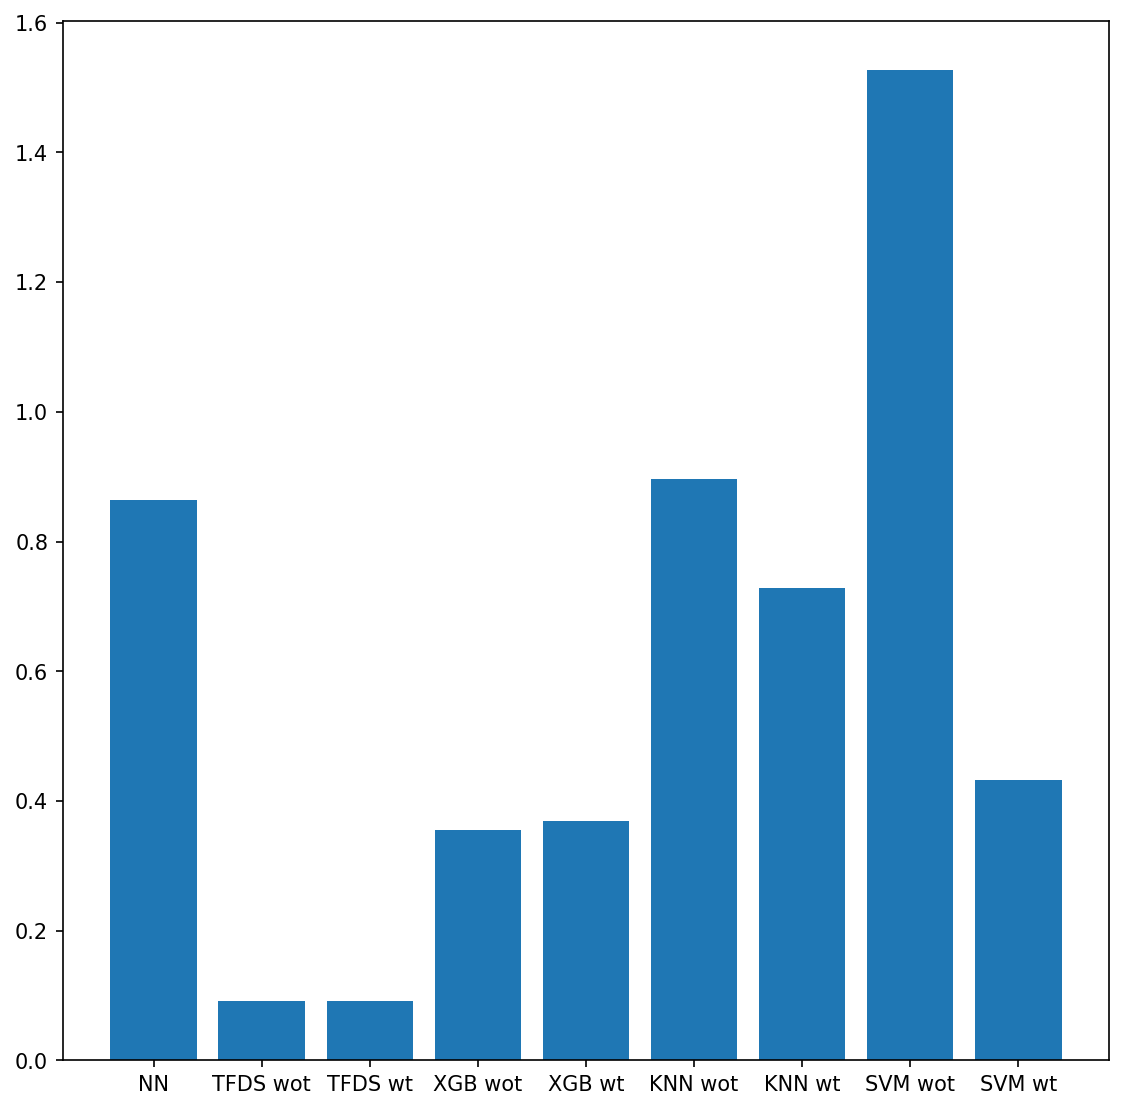

In [69]:
plt.figure(figsize=(9,9), dpi=150)
plt.bar(comparison_table['Models'], comparison_table['Loss']);
#To make the plot more clear Im going to change the name of the labels and make them shorter
#"wot" stand for WithOut Tunning and "wo" stands for With Tunning
plt.xticks(['Neural Network', 'Tensorflow Tree without tunning' , 'Tensorflow Tree with tunning', 'XGBoost without tunning', 'XGBoost with tunning', 'KNN without tunning', 'KNN with tunning', 'SVM without tunning', 'SVM with tunning'], ['NN', 'TFDS wot', 'TFDS wt', 'XGB wot', 'XGB wt', 'KNN wot', 'KNN wt', 'SVM wot', 'SVM wt'])
plt.show()